# 1. Importieren der benötigten Bibliotheken



In [ ]:
import os
import subprocess
import pandas as pd
import shutil
import tqdm
import glob
import pytest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import shapiro, binom_test, kstest, uniform
import numpy as np
import pandas as pd
import shutil
import numpy as np
import os
import random
import os
import pandas as pd
import os
import random
from PIL import Image
import numpy as np
from scipy.stats import kruskal
import os
from PIL import Image
import numpy as np
import cv2
from skimage import color, exposure


# 2. Datenpreparation für das ML-Modell


## 2.1 Festlegung der benötigten Variablen

In [ ]:
source_csv = "data/source_csv/list_attr_celeba.csv"
csv_path="data/source_csv/list_attr_celeba.csv"
source_train_path = "data/train-test-data/"
men_image_source_path_train = "data/train-test-data/train/men"
women_image_source_path_train = "data/train-test-data/train/women"
men_image_source_path_test = "data/train-test-data/test/men"
women_image_source_path_test = "data/train-test-data/test/women"
merged_csv_test = "model/csv_sheets/merged_df_test.csv"
merged_csv_train = "model/csv_sheets/merged_df_train.csv"
required_directories = [source_train_path, women_image_source_path_test,men_image_source_path_test,men_image_source_path_train,women_image_source_path_train]
# Hauptpfad zu den Bildern
base_path = "data/img_align_celeba"
IDs = "data/IDs"
id_column = 'image_id'
image_folder = "data/img_align_celeba"
total_images = 1000
male_csv = "data/IDs/male_ids.csv"
female_csv = "data/IDs/female_ids.csv"
os.makedirs(men_image_source_path_train, exist_ok=True)
os.makedirs(women_image_source_path_train, exist_ok=True)
os.makedirs(women_image_source_path_test,exist_ok=True)
os.makedirs(men_image_source_path_test,exist_ok=True)
os.makedirs(IDs,exist_ok=True)


## 2.1 Extraktion und Speicherung der Dateinamen aus dem Bilddaten Quellordner in eine CSV-Datei

In [ ]:
def save_filenames_to_csv(csv_path, csv_name=f"data/IDs/data-ids.csv", id_column="image_id"):
    df = pd.read_csv(csv_path)
    df = df[[id_column]]
    df.to_csv(csv_name, index=False)
    
save_filenames_to_csv(csv_path=csv_path)


## 2.2 Extraktion der IDs aus der Quell-CSV

In [ ]:
def extract_all_ids(csv_path, column="Male", id_column="image_id"):
    df = pd.read_csv(csv_path)
    df[column] = df[column].replace(-1, 0)
    df.to_csv(f'data/IDs/source_csv_all_ids.csv', columns=[id_column], index=False)
    
extract_all_ids(csv_path=csv_path)

## 2.3 Überprüfung auf Vollständigkeit der Bilddaten durch den Vergleich der Dateinamen aus img_align_celeba und der IDs aus der Quell-CSV 

In [ ]:
def compare_columns(csv1, csv2):
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)
    column1 = df1.iloc[:, 0]
    column2 = df2.iloc[:, 0]
    is_equal = column1.equals(column2)
    return is_equal

if compare_columns(f'data/IDs/source_csv_all_ids.csv', f'data/IDs/data-ids.csv') == True: 
    print("::warning:: Daten sind vollständig! Die Bilddaten-IDs stimmen mit den IDs aus Attributliste überein! ")
else: 
    print("::warning:: Daten sind unvollständig! Die Bilddaten-IDs stimmen nicht mit den IDs aus der Attributliste überein! ")


## 2.4 Extraktion der IDs aus der Quell-CSV in Abhängigkeit der Spalte "Male"

In [ ]:
def extract_ids(csv_path, column="Male", id_column="image_id"):
    df = pd.read_csv(csv_path)
    df[column] = df[column].replace(-1, 0)
    male_df = df[df[column] == 1]
    female_df = df[df[column] == 0]
    male_df.to_csv(f'data/IDs/male_ids.csv', columns=[id_column], index=False)
    female_df.to_csv(f'data/IDs/female_ids.csv', columns=[id_column], index=False)
    
extract_ids(csv_path=csv_path)

## 2.5 Löschung von Bilddaten, falls Trainings- und Testordner bereits befüllt sind

In [ ]:

def clear_directory(dir_path):
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

clear_directory(men_image_source_path_train)
clear_directory(women_image_source_path_train)
clear_directory(women_image_source_path_test)
clear_directory(men_image_source_path_test)

## 2.6 Verteilung der (neuen) Bilddaten in Trainings- und Testordner

In [ ]:
def get_ids_from_csv(csv_file, id_column):
    df = pd.read_csv(csv_file)
    ids = df[id_column].tolist()
    return ids



def split_data_random(image_folder, male_csv, female_csv, total_images, id_column, train_ratio=0.7):
    print(total_images)
    male_ids = get_ids_from_csv(male_csv, id_column)
    female_ids = get_ids_from_csv(female_csv, id_column)
    
   
    num_train = int(total_images * train_ratio)
    num_test = int(total_images - num_train)

    test_ids_male = random.sample(male_ids, num_test // 2)
    test_ids_female = random.sample(female_ids, num_test // 2)
    test_ids = test_ids_male + test_ids_female
   
    train_ids_male = set(male_ids) - set(test_ids) 
    train_ids_female = set(female_ids) - set(test_ids)
    male_ids = sorted(train_ids_male)
    female_ids = sorted(train_ids_female)
    female_ids = random.sample(female_ids,num_train//2)
    male_ids = random.sample(male_ids,num_train//2)
    
    for id in test_ids_male:
        shutil.copy(os.path.join(image_folder, id), men_image_source_path_test)
    
    for id in test_ids_female:
        shutil.copy(os.path.join(image_folder, id), women_image_source_path_test)

    for id in male_ids:
        shutil.copy(os.path.join(image_folder, id), men_image_source_path_train)
    
    for id in female_ids:
        shutil.copy(os.path.join(image_folder, id), women_image_source_path_train)

split_data_random(image_folder, male_csv,female_csv,total_images, id_column)

## 2.7 Testen ob die Bildpfade in der CSV-Datei die richtige Dateiendung haben. 

In [ ]:


# Erstellen der source.csv um automatisch die benötigten Spalten für die Visualisierung der Daten herauszuziehen.
df = pd.read_csv(csv_path)
df.to_csv("data/column_source_csv/source.csv", index=False)

# Extrahiert aus dem Source Pfad die Bildpfade
def get_image_paths(source_path):
    image_formats = ['*.jpg', '*.png', '*.gif', '*.jpeg']
    image_paths = []
    for format in image_formats:
        image_paths.extend(glob.glob(os.path.join(source_path, format)))
    return image_paths

# Testet ob die Bilder in der CSV-Datei die richtigen Dateiendungen haben
def test_image_extensions_in_csv(csv_path, column_name_of_image_paths="image_id"):
    df = pd.read_csv(csv_path)

    # Überprüfe, ob alle Werte in der Spalte 'image_id' auf Bilddateien verweisen
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    df['valid_extension'] = df[column_name_of_image_paths].apply(lambda x: os.path.splitext(x)[1].lower() in valid_extensions)

    # Drucke die Zeilennummern mit ungültiger Dateierweiterung, wenn es welche gibt
    invalid_rows = df[~df['valid_extension']].index
    if len(invalid_rows) > 0:
        print(f'Ungültige Dateierweiterungen gefunden in den Zeilen: {invalid_rows.tolist()}')

    assert all(df['valid_extension']), f'Nicht alle Werte in der Spalte {column_name_of_image_paths} verweisen auf Bilddateien./n {invalid_rows} /n Überprüfe die Dateierweiterungen.'

# Extrahieren der Bildpfade auf img_align_celeba
image_paths_array = get_image_paths(base_path)
test_image_extensions_in_csv(csv_path=csv_path, column_name_of_image_paths=id_column)
# # Erstellen eines Dataframes mit der Source CSV 
# df = pd.read_csv("data/source_csv/list_attr_celeba.csv")
# df['image_id'] = df['image_id'].str.replace("C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/", "")
# df.to_csv("data/source_csv/list_attr_celeba.csv", index=False)

## 2.8 Überprüfen ob die source.csv im Dateiformat CSV ist. 


In [ ]:
def check_csv_extension(csv_path):
    _, ext = os.path.splitext(csv_path)
    assert ext.lower() == '.csv', f'Die Datei {csv_path} hat keine .csv Erweiterung'
    
check_csv_extension(csv_path)

## 2.9 Überprüfen ob die benötigten Ordner vorhanden sind zum trainieren, testen, speichern der ML-Modelle

In [ ]:
def check_required_directories_data_exists(directories):
    for directory in directories:
        assert os.path.isdir(directory), f'Das Verzeichnis {directory} existiert nicht'

check_required_directories_data_exists(required_directories)

## 2.10 Überprüfung der Bildqualität

In [17]:


def calculate_average_image_quality(directory, image_sample_size=10000):
    total_contrast = 0
    total_brightness = 0
    total_sharpness = 0
    total_entropy = 0
    total_saturation = 0
    i = 0
    image_files = os.listdir(directory)
    image_paths = [os.path.join(directory, img) for img in image_files if img.endswith('.jpg')]

    for image_path in image_paths:
        if i == image_sample_size:
            break
        # Bild öffnen
        img = Image.open(image_path).convert('RGB')  # Bild in RGB konvertieren
        img_gray = np.array(img.convert('L'))  # Graustufenbild für einige Metriken

        # Kontrast berechnen
        contrast = img_gray.std()
        total_contrast += contrast

        # Helligkeit berechnen
        brightness = img_gray.mean()
        total_brightness += brightness

        # Schärfe berechnen
        gy, gx = np.gradient(img_gray)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        total_sharpness += sharpness

        # Entropie berechnen
        hist = exposure.histogram(img_gray)
        entropy = -np.sum(hist * np.log2(hist + np.finfo(float).eps))
        total_entropy += entropy

        # Sättigung berechnen
        hsv_img = color.rgb2hsv(np.array(img))
        saturation = np.mean(hsv_img[:, :, 1])
        total_saturation += saturation

        i += 1

    # Durchschnitt berechnen
    avg_contrast = total_contrast / image_sample_size
    avg_brightness = total_brightness / image_sample_size
    avg_sharpness = total_sharpness / image_sample_size
    avg_entropy = total_entropy / image_sample_size
    avg_saturation = total_saturation / image_sample_size

    return avg_contrast, avg_brightness, avg_sharpness, avg_entropy, avg_saturation

# Funktion aufrufen
directory = "data/img_align_celeba"
avg_contrast, avg_brightness, avg_sharpness, avg_entropy, avg_saturation = calculate_average_image_quality(directory)
print(f'Durchschnittlicher Kontrast: {avg_contrast}, Durchschnittliche Helligkeit: {avg_brightness}, Durchschnittliche Schärfe: {avg_sharpness}, Durchschnittliche Entropie: {avg_entropy}, Durchschnittliche Sättigung: {avg_saturation}')

Durchschnittlicher Kontrast: 62.70878023983905, Durchschnittliche Helligkeit: 113.55603754509822, Durchschnittliche Schärfe: 8.066046423047403, Durchschnittliche Entropie: -533857.990005628, Durchschnittliche Sättigung: 0.3589371348676617


# 3 Datenqualität testen

## 3.1 Überprüfen ob Bilddateien fehlen, Duplicate vorhanden sind, Überprüfen ob die Bildpfade gültig sind in der CSV. 

In [ ]:
def test_quality_of_csv(csv_path,column_name_of_image_paths="image_id"):
    df = pd.read_csv(csv_path)

    # Überprüfe auf fehlende Werte
    assert df[column_name_of_image_paths].isnull().sum() == 0, f'Es gibt fehlende Werte in der Spalte {column_name_of_image_paths}'

    # Überprüfe auf Duplikate
    assert df.duplicated().sum() == 0, "Es gibt Duplikate in der Daten"
    
    # # Überprüfe, ob alle Werte in der Spalte 'image_id' gültige Bildpfade sind
    # assert all(df[column_name_of_image_paths].apply(os.path.isfile)), f'Nicht alle Werte in der Spalte {column_name_of_image_paths} sind gültige Bildpfade./n {df[column_name_of_image_paths].sample(10)} /n Überprüfe, ob der Pfad vorhanden ist.' 

test_quality_of_csv(csv_path=csv_path, column_name_of_image_paths=df.columns[0])

## 3.2 Überprüfen ob es in allen Spalten Werte gibt die null bzw. leer sind.

In [ ]:
def check_missing_values(csv_path):
    df = pd.read_csv(csv_path)
    missing_values = df.isnull().any()
    
    return missing_values

check_missing_values(csv_path=csv_path)

## 3.3 Überprüfen ob es Anomalien, Ausreißer gibt

In [ ]:
def test_outliers_all_columns(csv_path):
    df = pd.read_csv(csv_path)
    for column_name in df.columns:
        if np.issubdtype(df[column_name].dtype, np.number):  # Überprüfe, ob die Spalte numerisch ist
            z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
            if any(z_scores > 3):
                print(f"::warning::Es gibt Ausreißer in der Spalte '{column_name}'")

test_outliers_all_columns(csv_path=csv_path)

## 3.4 Überprüfen ob die Daten ausgeglichen sind

In [ ]:
def test_balance_all_columns(csv_path):
    df = pd.read_csv(csv_path)
    imbalance_report = []

    for column_name in df.columns:
        if np.issubdtype(df[column_name].dtype, np.number):  # Überprüfe, ob die Spalte numerisch ist
            counts = df[column_name].value_counts()
            if abs(counts.get(-1, 0) - counts.get(1, 0)) >= 0.1 * len(df):
                imbalance_report.append(f"Die Spalte '{column_name}' ist unausgeglichen. Anzahl von -1: {counts.get(-1, 0)}, Anzahl von 1: {counts.get(1, 0)}")

    if imbalance_report:
        print("Es gibt unausgeglichene Spalten:/n" + "/n".join(imbalance_report))

def is_numeric(column):
    try:
        pd.to_numeric(column)
        return True
    except ValueError:
        return False

# Load your DataFrame
df = pd.read_csv('data/column_source_csv/source.csv')

# Filter the columns to only those with numeric data
numeric_columns = [col for col in df.columns if is_numeric(df[col])]

df = df[numeric_columns]
df.to_csv("data/column_source_csv/source.csv", index=False)



def plot_balance_all_columns(csv_path):
    df = pd.read_csv(csv_path)

    for column_name in df.columns:
        if np.issubdtype(df[column_name].dtype, np.number):  # Überprüfe, ob die Spalte numerisch ist
            counts = df[column_name].value_counts()
            counts.plot(kind='bar', title=f"Verteilung der Werte in der Spalte '{column_name}'")
            plt.savefig(f"data/plot_data/{column_name}.png")
            plt.show()
            
        
test_balance_all_columns(csv_path=csv_path)
plot_balance_all_columns(csv_path=csv_path)

## 3.5 Datensatz auf Ausreißer überprüfen

In [ ]:
def detect_all_outliers(df):
    outliers_percentage = {}
    
    # Gehe durch jede Spalte im DataFrame
    for column_name in df.columns:
        # Überspringe nicht-numerische Spalten
        if pd.api.types.is_numeric_dtype(df[column_name]):
            # Berechne den IQR-Score
            Q1 = df[column_name].quantile(0.25)
            Q3 = df[column_name].quantile(0.75)
            IQR = Q3 - Q1

            # Definiere die Grenzen für Ausreißer
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Finde die Ausreißer
            outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
            
            # Berechne den Prozentsatz der Ausreißer
            outliers_percentage[column_name] = len(outliers) / len(df) * 100
    
    return outliers_percentage


def detect_outliers(df, column_name):
    # Berechne den IQR-Score
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Definiere die Grenzen für Ausreißer
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Finde die Ausreißer
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]

    return outliers


df = pd.read_csv(csv_path)
detect_all_outliers(df)

## 3.6 Visualisierung der Daten

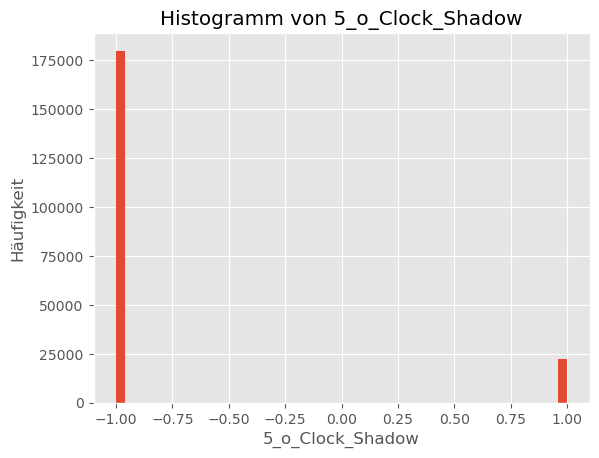

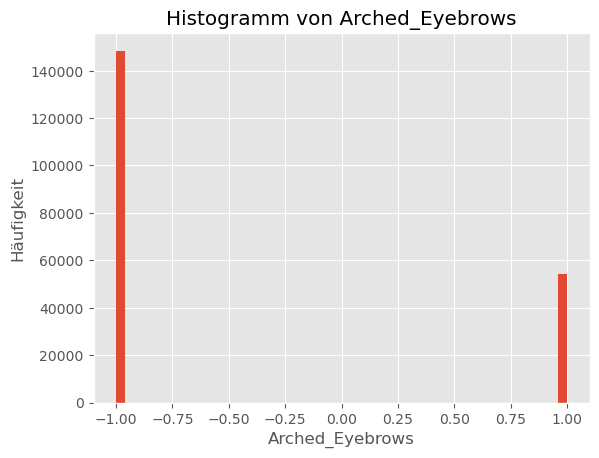

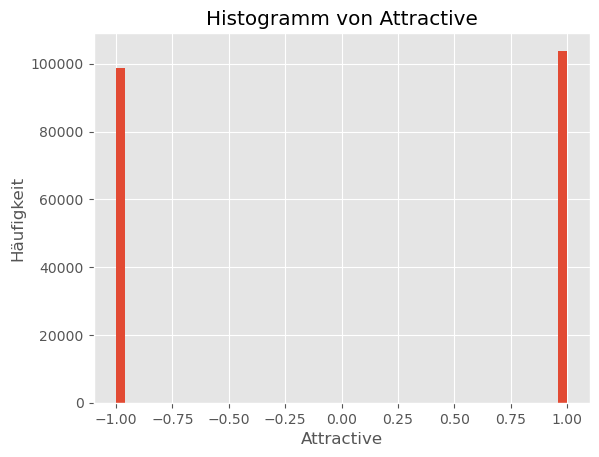

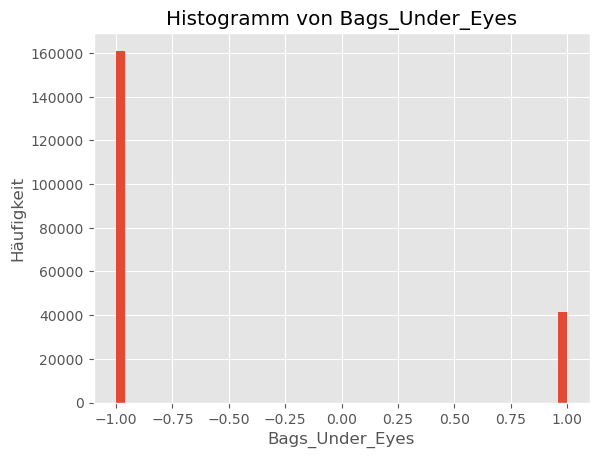

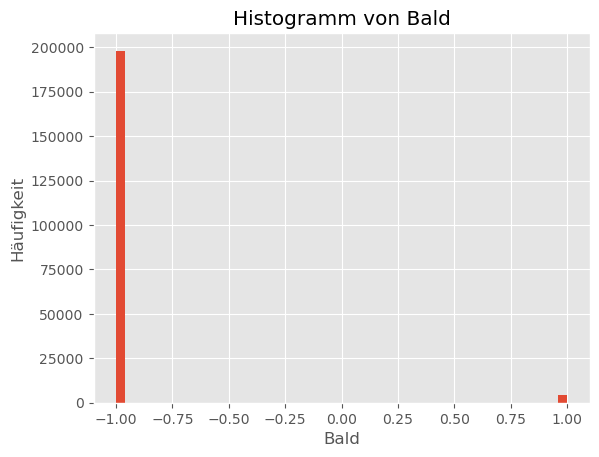

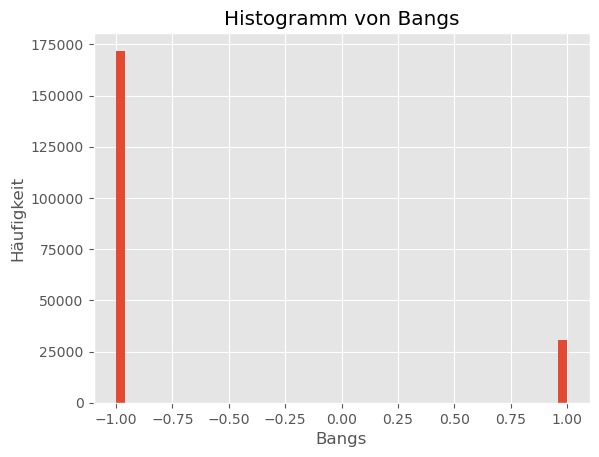

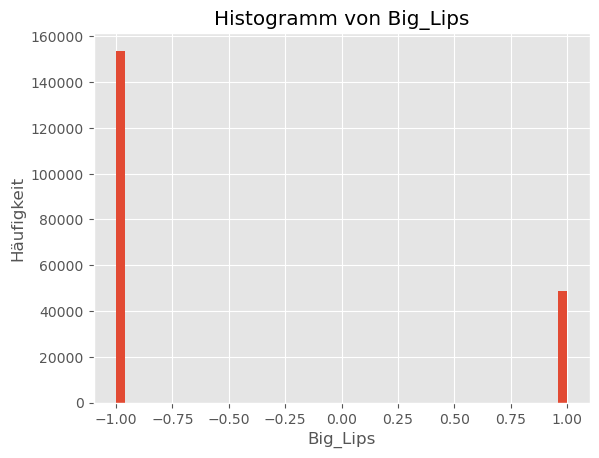

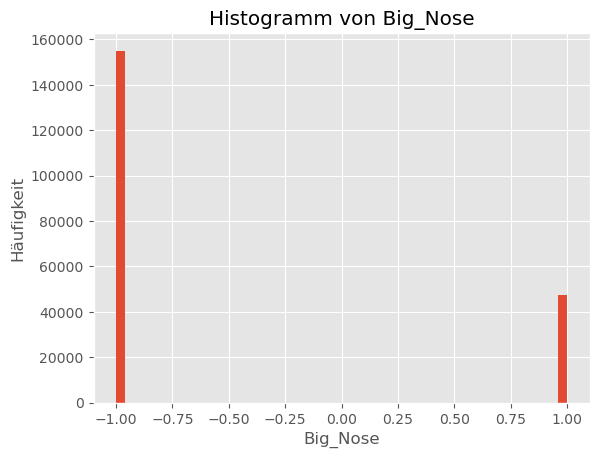

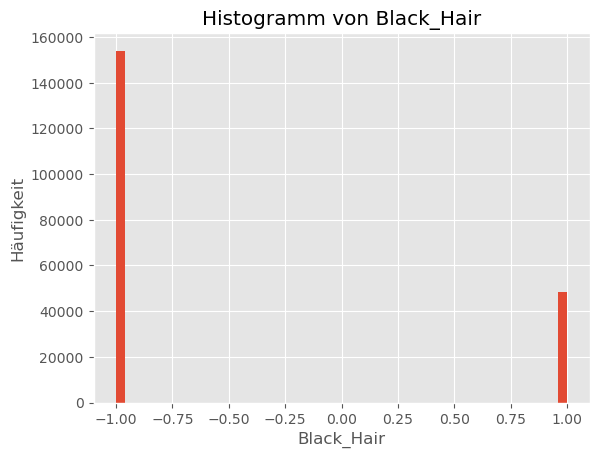

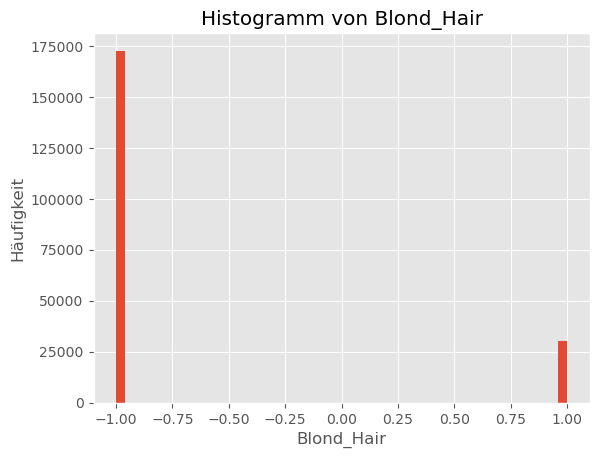

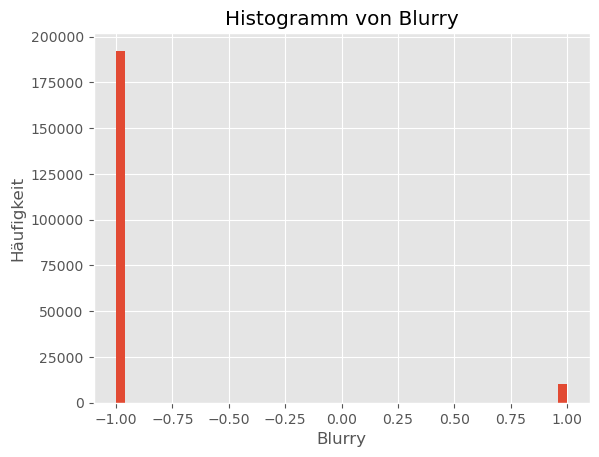

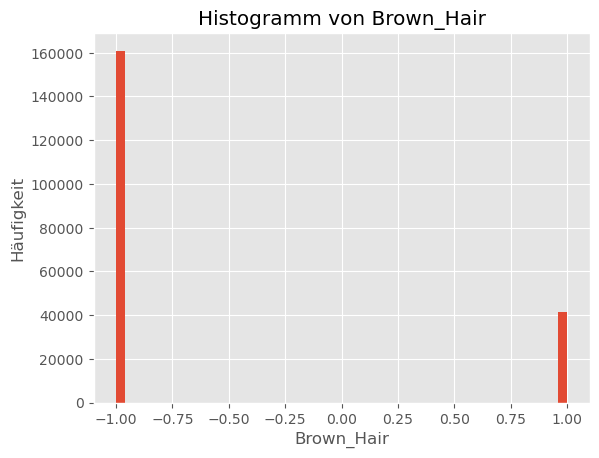

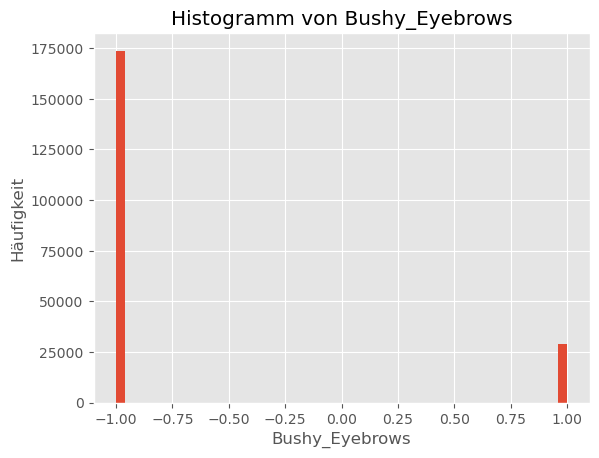

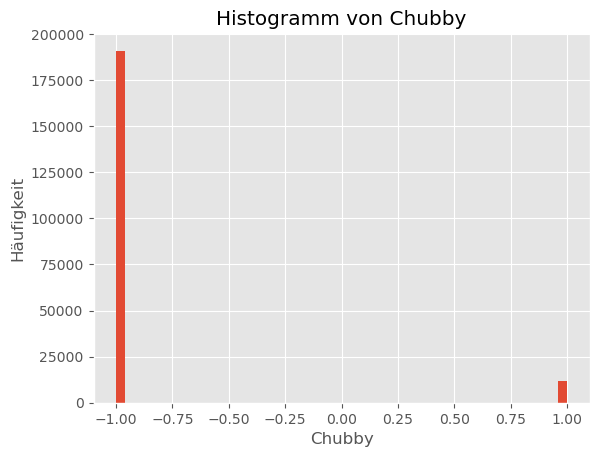

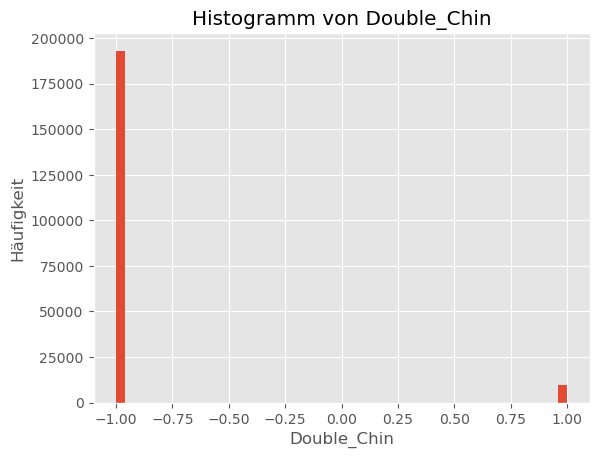

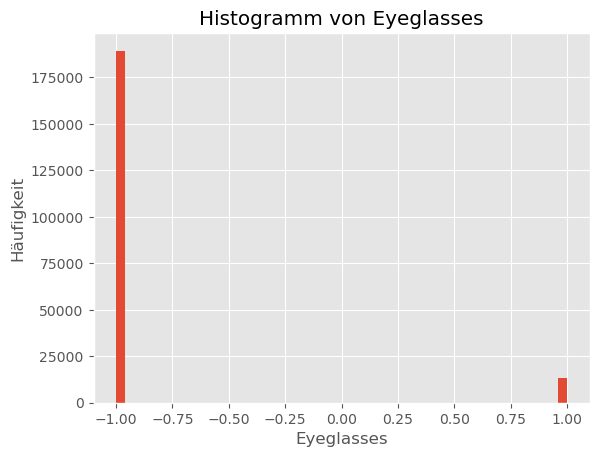

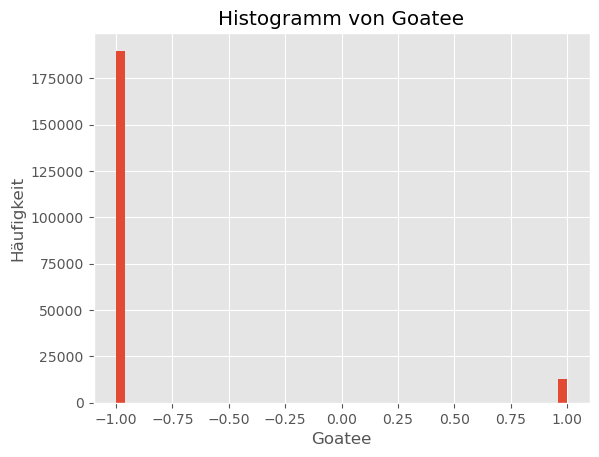

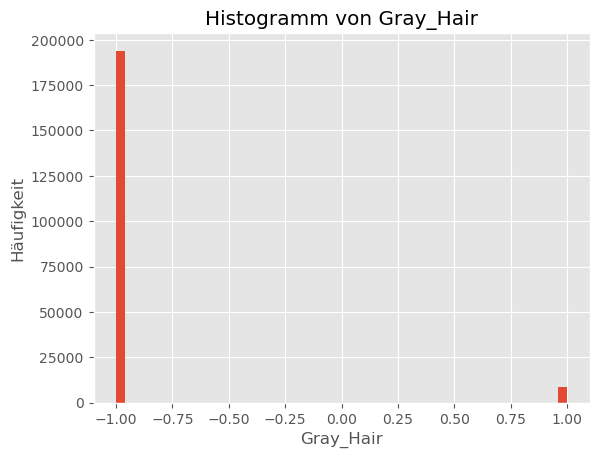

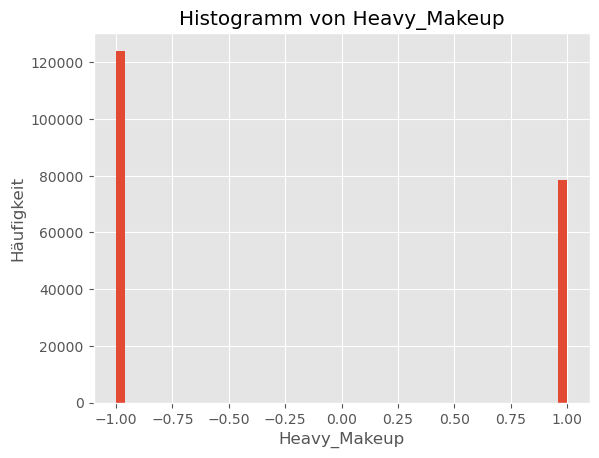

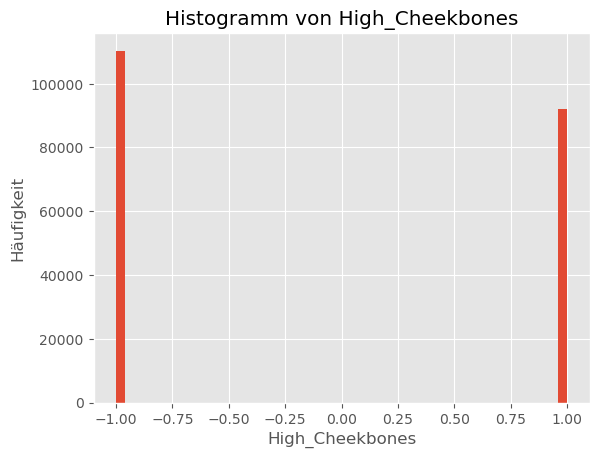

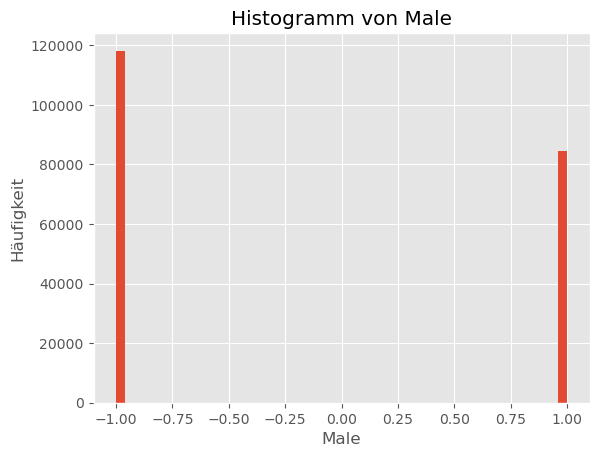

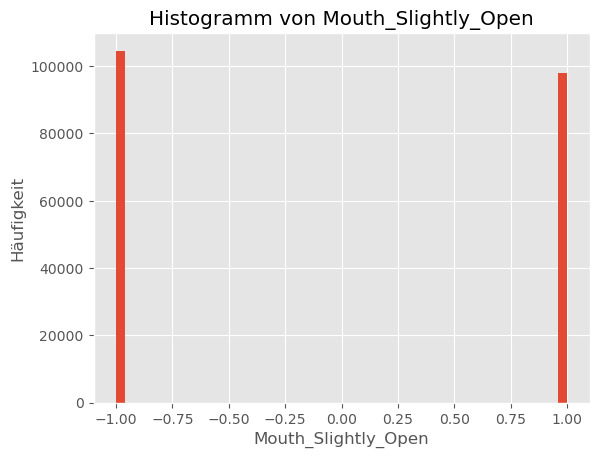

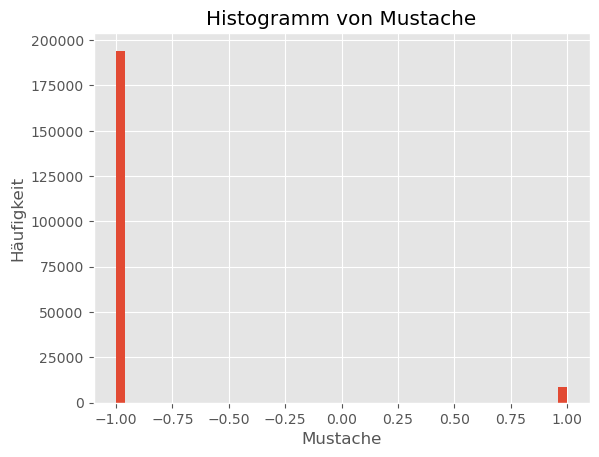

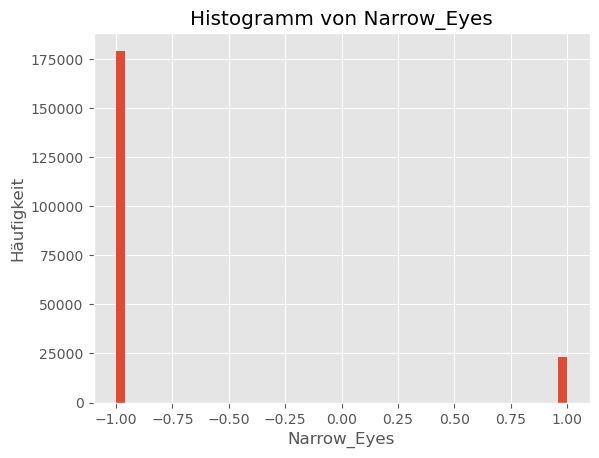

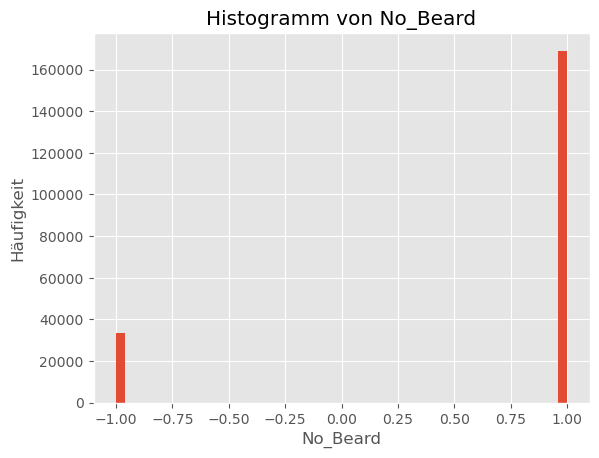

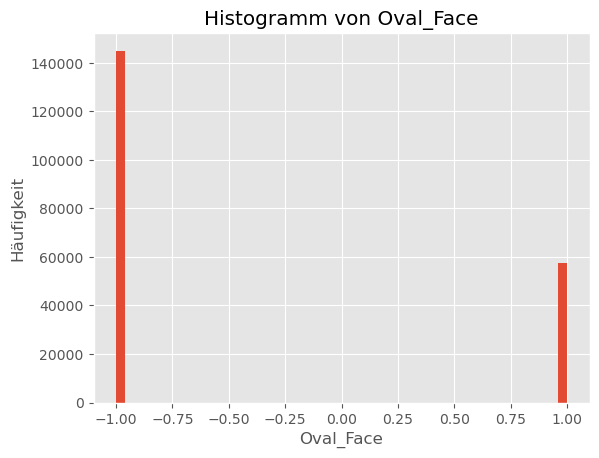

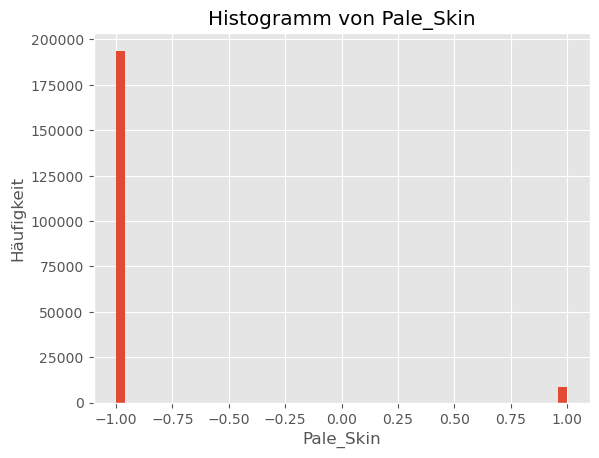

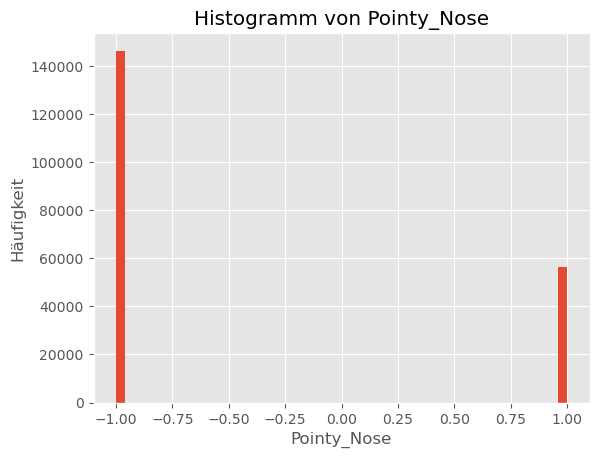

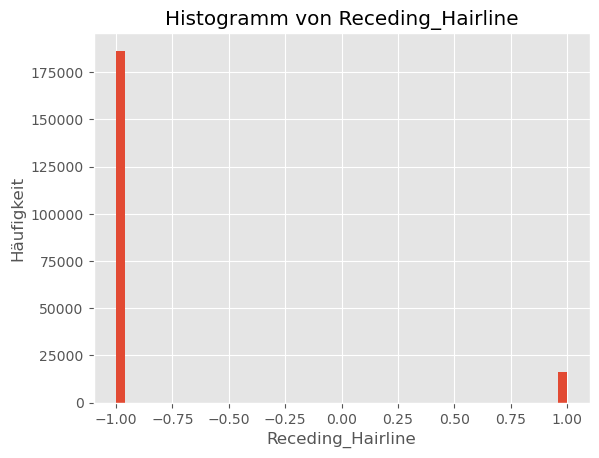

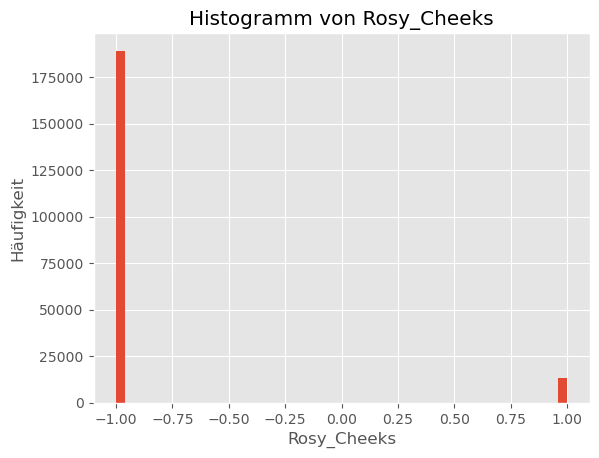

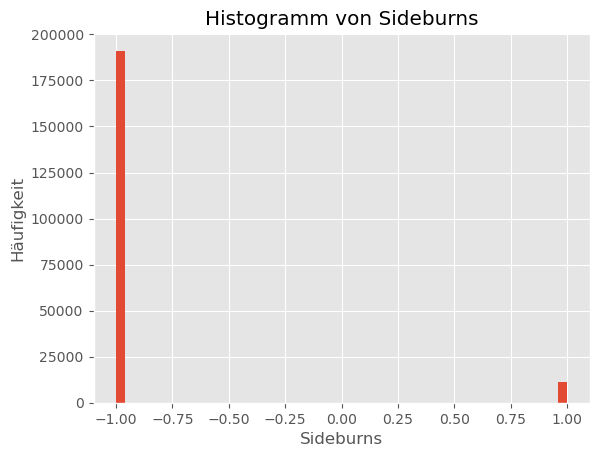

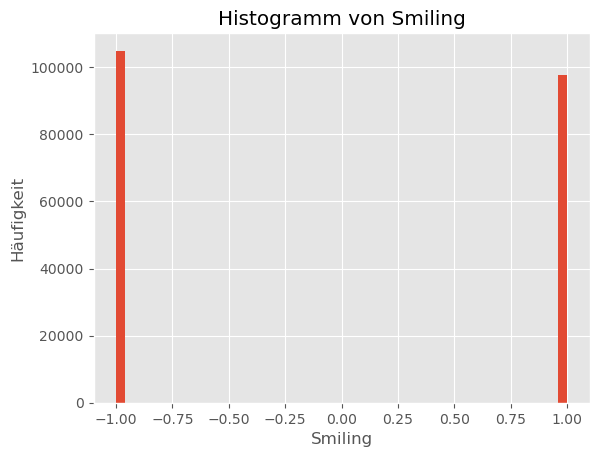

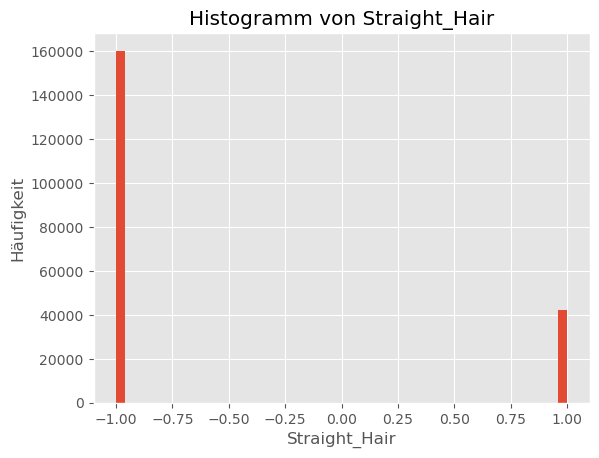

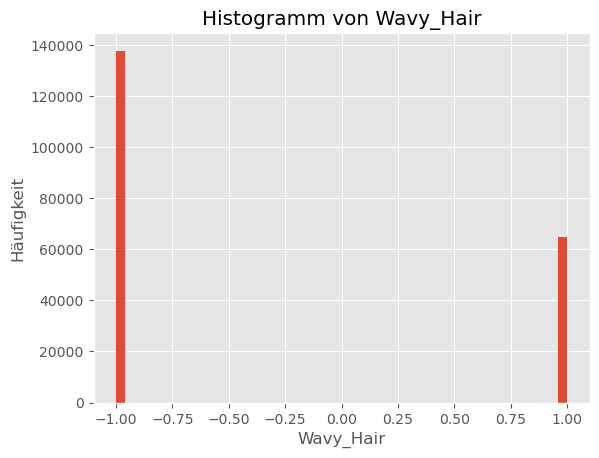

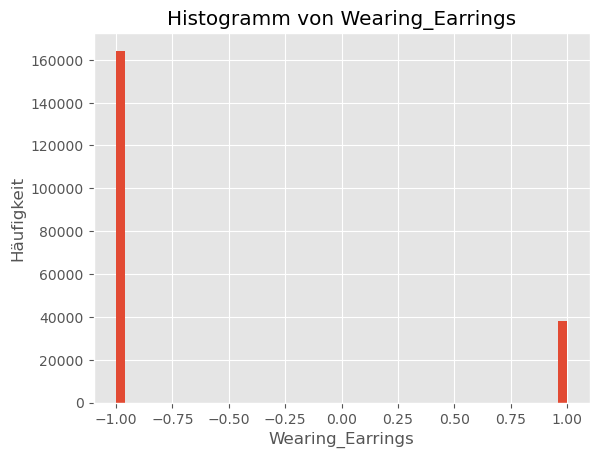

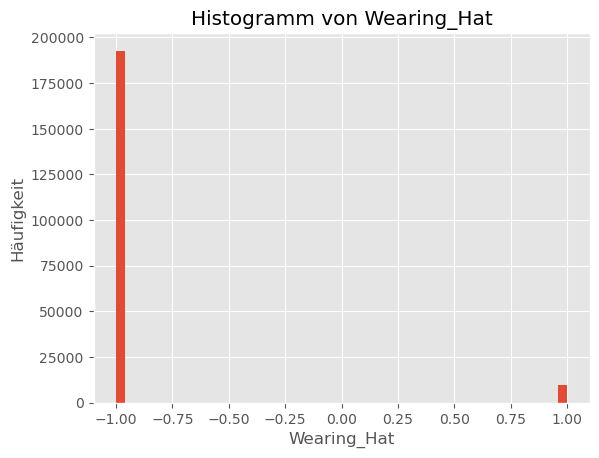

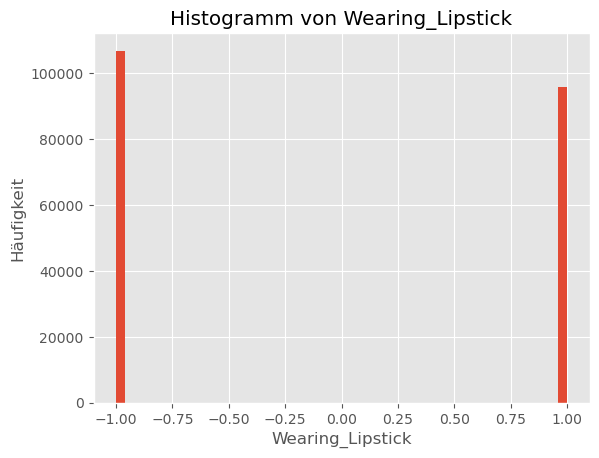

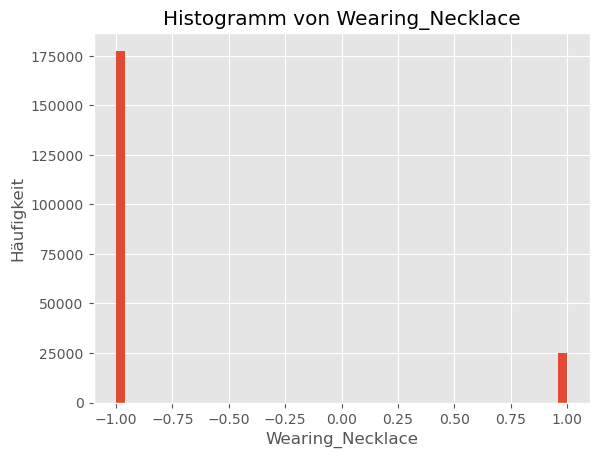

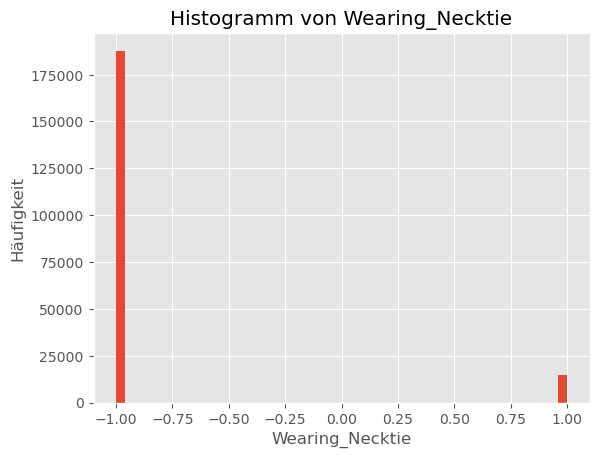

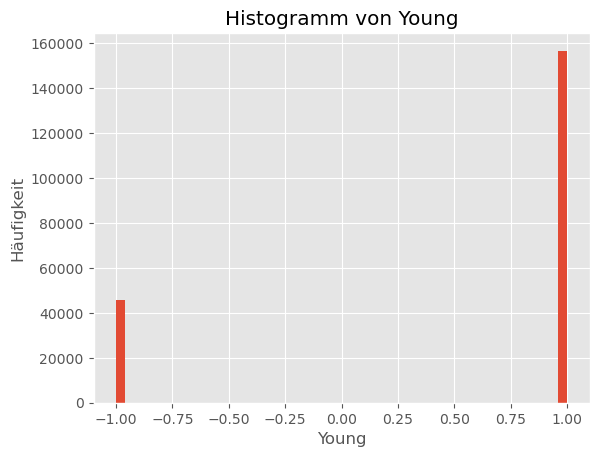

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms(csv_file):
    # CSV-Datei in einen DataFrame einlesen, um die Anzahl der Spalten zu ermitteln
    df = pd.read_csv(csv_file)
    num_cols = len(df.columns)

    # CSV-Datei erneut einlesen, erste Spalte überspringen
    df = pd.read_csv(csv_file, usecols=range(1, num_cols))

    # Für jede Spalte im DataFrame
    for column in df.columns:
        # Histogramm erstellen
        plt.figure()
        df[column].hist(bins=50)
        plt.title(f'Histogramm von {column}')
        plt.xlabel(column)
        plt.ylabel('Häufigkeit')
        plt.style.use('ggplot')
        plt.savefig(f"data/plot_data/{column}.png")
        # Histogramm anzeigen
        plt.show()

plot_histograms("data/source_csv/list_attr_celeba.csv")

# 4 Unausgeglichenheit der Daten von ein Paar Datensätzen auflösen um das Verhalten auf das ML-Modell zu beobachten

## 4.1 Anpassen der Unausgeglichenheit zwischen Frauen und Mann Datensätzen

In [ ]:
def plot_gender_histogram(df):
    # Zähle die Anzahl von Frauen und Männern
    counts = df['Male'].value_counts()

    # Plotte die Daten
    plt.bar(['Female', 'Male'], [counts[-1], counts[1]], color=['#ff69b4', '#1f77b4'])

    # Schreibe Text auf die Balken
    for i, v in enumerate([counts[-1], counts[1]]):
        plt.text(i, v, str(v), fontsize=12, ha='center', va='bottom')

    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()


def balance_column(csv_path, column_name):
    # Lade die CSV-Datei in einen DataFrame
    df = pd.read_csv(csv_path)

    # Zähle die Anzahl von -1 und 1
    counts = df[column_name].value_counts()

    # Finde den kleineren Wert
    min_count = min(counts.get(-1, 0), counts.get(1, 0))

    # Erstelle einen neuen DataFrame mit einer ausgeglichenen Anzahl von -1 und 1
    df_balanced = pd.concat([
        df[df[column_name] == -1].sample(min_count),
        df[df[column_name] == 1].sample(min_count)
    ], axis=0)

    return df_balanced


# Call the function with your csv file
balanced_df = balance_column(source_csv, "Male")
balanced_df.to_csv("data/balanced_source_csv/balanced_gender.csv", index=False)

balanced_csv_path ="data/balanced_source_csv/balanced_gender.csv"
plot_gender_histogram(balanced_df)


## 4.2 Unausgeglichenheit zwischen Jungen und Alten Personendatensätzen ausgleichen

In [ ]:
def plot_young_histogram(df):
    # Zähle die Anzahl von Frauen und Männern
    counts = df["Young"].value_counts()

    # Plotte die Daten
    plt.bar(['not Young', 'Young'], [counts[-1], counts[1]], color=['#ff69b4', '#1f77b4'])

    # Schreibe Text auf die Balken
    for i, v in enumerate([counts[-1], counts[1]]):
        plt.text(i, v, str(v), fontsize=12, ha='center', va='bottom')
    plt.title('Young oder nicht Young ohne Balanced Gender Data')
    plt.xlabel('Young or not Young')
    plt.ylabel('Count')
    plt.show()

young_balanced_csv = "data/balanced_source_csv/balanced_young.csv"
df_young_balanced = balance_column(source_csv, "Young")
df_young_balanced.to_csv("data/balanced_source_csv/balanced_young.csv", index=False)
df_young_balanced = pd.read_csv(young_balanced_csv)

plot_young_histogram(df_young_balanced)



# 5. Datenverteilung Testen

## 5.1 Daten auf Normalverteilung testen

In [ ]:
from scipy.stats import shapiro
from scipy.stats import kstest, uniform
import pandas as pd
from scipy.stats import kruskal


def test_normal_distribution(data, column_name):
    # Führe den Shapiro-Wilk-Test durch
    stat, p = shapiro(data)

    # Überprüfe das Ergebnis
    if p > 0.05:
        result = f'::warning::Die Daten in der Spalte {column_name} folgen wahrscheinlich einer Normalverteilung.'
    else:
        result = f'::warning::Die Daten in der Spalte {column_name} folgen wahrscheinlich nicht einer Normalverteilung.'

    with open("data/reports_data/norm_distribution.txt", "w") as f:
        f.write(result + "\n")

# Call the function with your data
for column_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[column_name]):
        test_normal_distribution(df[column_name], column_name)


### Funktion: test_image_brightness

**Beschreibung:**  
Führt den Kruskal-Wallis-Test auf den Helligkeitswerten einer zufälligen Auswahl von Bildern aus einem Verzeichnis durch.

**Parameter:**  
- `directory` (str): Der Pfad zum Verzeichnis, das die Bilder enthält.
- `num_images` (int, optional): Die Anzahl der zufällig auszuwählenden Bilder. Standardmäßig 3.
- `num_pixels` (int, optional): Die Anzahl der zufällig aus jedem Bild auszuwählenden Pixel. Standardmäßig 1000.

**Returns:**  
- `stat` (float): Der Wert der Teststatistik des Kruskal-Wallis-Tests.
- `p` (float): Der p-Wert des Kruskal-Wallis-Tests.

**Beispiel:**

```python
directory = "data/img_align_celeba"
stat, p = test_image_brightness(directory, num_images=5)
print(f'Statistik: {stat}, p-Wert: {p}')

In [25]:


def test_image_brightness(directory, num_images=3, num_pixels=1000):
    # Liste aller Bilder im Verzeichnis
    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    
    # Zufällige Auswahl von Bildern
    selected_images = random.sample(image_files, num_images)
    
    # Liste zur Speicherung der Helligkeitswerte
    brightness_values = []
    
    for image_file in selected_images:
        # Bild öffnen und in Graustufen konvertieren
        img = Image.open(os.path.join(directory, image_file)).convert('L')
        img_array = np.array(img)
        
        # Zufällige Auswahl von Pixeln
        pixel_indices = random.sample(range(img_array.size), num_pixels)
        selected_pixels = img_array.ravel()[pixel_indices]
        
        # Helligkeitswerte speichern
        brightness_values.append(selected_pixels)
    
    # Kruskal-Wallis-Test durchführen
    stat, p = kruskal(*brightness_values)
    
    return stat, p

# Funktion aufrufen
directory = "data/img_align_celeba"
stat, p = test_image_brightness(directory, num_images=5)
print(f'Statistik: {stat}, p-Wert: {p}')

Statistik: 972.6899501886633, p-Wert: 2.957314465910528e-209


## 5.2 Daten auf Uniformverteilung/Gleichverteilung testen

In [ ]:
def test_uniform_distribution(data, column_name):
    # Generiere theoretische Werte für die Uniformverteilung
    theoretical_values = uniform.rvs(size=len(data))

    # Führe den KS-Test durch
    stat, p = kstest(data, theoretical_values)

    # Überprüfe das Ergebnis
    if p > 0.05:
        result = f'::warning::Die Daten in der Spalte {column_name} folgen wahrscheinlich einer Uniformverteilung.'
    else:
        result = f'::warning::Die Daten in der Spalte {column_name} wahrscheinlich nicht einer Uniformverteilung.'

    with open("data/reports_data/uniform_distribution.txt", "w") as f:
        f.write(result)

# Call the function with your data
for column_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[column_name]):
        test_uniform_distribution(df[column_name], column_name)

## 5.3 Daten auf Binomialverteilung testen

In [ ]:
import pandas as pd

def test_bernoulli_distribution(data, column_name, p):
    data = data.replace(-1, 0) 
    value_counts = data.value_counts() 
    observed_values = [value_counts.get(1, 0), value_counts.get(0, 0)]
    n = len(data)

    # Berechne die erwarteten Werte
    expected_values = [n*p, n*(1-p)]

    # Überprüfe, ob die beobachteten Werte den erwarteten Werten entsprechen
    if abs(observed_values[0] - expected_values[0]) / n < 0.05 and abs(observed_values[1] - expected_values[1]) / n < 0.05:
        result = f'Die Daten in der Spalte {column_name} folgen wahrscheinlich einer Binomial-Verteilung.'
    else:
        result = f'Die Daten in der Spalte {column_name} folgen wahrscheinlich nicht einer Binomial-Verteilung.'

    with open("data/reports_data/binomial_distribution.txt", "w") as f:
        f.write(result)

for column_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[column_name]):
        test_bernoulli_distribution(df[column_name], column_name, p=0.5)

## 5.4 Daten auf Exponentialverteilung testen

In [ ]:
from scipy.stats import kstest

def test_exponential_distribution(data, column_name):
    stat, p_value = kstest(data, 'expon')
    if p_value > 0.05:
        result = f'Die Daten in der Spalte {column_name} folgen wahrscheinlich einer Exponentialverteilung.'
    else:
        result = f'Die Daten in der Spalte {column_name} folgen wahrscheinlich nicht einer Exponentialverteilung.'

    with open("data/reports_data/exponential_distribution.txt", "w") as f:
        f.write(result)

for column_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[column_name]):  
        # Entfernen Sie nicht-numerische Werte
        data = df[column_name].dropna()
        test_exponential_distribution(data, column_name)